In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
file_path = '/content/drive/My Drive/diagnosed_cbc_data_v4.csv'
df = pd.read_csv(file_path)

In [ ]:
pip install imbalanced-learn

In [ ]:
!pip install pennylane numpy pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.0 MB/s eta 0:00:00


In [ ]:
!pip install pennylane-lightning[gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import time
import pennylane as qml
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # Importation de SMOTE

file_path = '/content/drive/My Drive/diagnosed_cbc_data_v4.csv'
df = pd.read_csv(file_path)

# ✅ Supprimer les classes ayant moins de 59 occurrences
min_samples = 73
class_counts = df['Diagnosis'].value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
df = df[df['Diagnosis'].isin(valid_classes)]

# Afficher les classes restantes
print("✅ Classes restantes après suppression :")
print(df['Diagnosis'].value_counts())

# Split features and target variable
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']
# Standardiser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


✅ Classes restantes après suppression :
Diagnosis
Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Name: count, dtype: int64


In [ ]:

# Configuration du dispositif quantique (en utilisant au maximum 12 fils comme nécessaire)
max_qubits = 16
device = qml.device("default.qubit", wires=max_qubits)

# Définir le QNode avec AngleEmbedding
def create_qnode(num_qubits):
    @qml.qnode(device)
    def qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(num_qubits), rotation="Y")
        qml.adjoint(qml.AngleEmbedding(weights, wires=range(num_qubits), rotation="Y"))
        return qml.probs(wires=range(num_qubits))
    return qnode

# Calcul du noyau quantique
def qkernel(X1, X2, qnode_func):
    return np.array([[qnode_func(x1, x2)[0] for x2 in X2] for x1 in X1])

# Grid de paramètres
pca_components = range(8, 11)  # de 8 à 10 composants
C_value = 1000  # Fixer C à 1000

# Stocker les résultats ici
results = []

# Boucle principale
for n_components in pca_components:
    print(f"Testing PCA = {n_components} components")

    # Transformation PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Séparer en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, random_state=42, stratify=y)

    # Appliquer SMOTE sur le jeu d'entraînement
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Déterminer le nombre de qubits (prochain puissance de 2)
    num_qubits = int(np.ceil(np.log2(n_components)))
    wires = 2**num_qubits

    # Créer le QNode pour le nombre actuel de qubits
    qnode = create_qnode(wires)

    # Utiliser l'ensemble d'entraînement comme poids
    weights = X_train_resampled

    # Entraînement du SVM avec C = 1000
    print(f"    Training SVM with C = {C_value}")
    start_time = time.time()

    # Définir SVC avec le noyau quantique
    qsvm = SVC(kernel=lambda X1, X2: qkernel(X1, X2, qnode), C=C_value, gamma='scale')  # Passage de qnode_func à qkernel
    qsvm.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()

    preds = qsvm.predict(X_test)
    acc = accuracy_score(y_test, preds)
    clf_report = classification_report(y_test, preds, output_dict=True)
    print(f"  accuracy = {acc:.4f}")
    results.append({
        "PCA_components": n_components,
        "C_value": C_value,
        "Accuracy": acc,
        "Train_time": end_time - start_time,
        "Classification_Report": clf_report
    })

# Sauvegarder les résultats dans un fichier CSV
df_results = pd.DataFrame(results)
df_results.to_csv("quantum_svm_results.csv", index=False)
print("Results saved to quantum_svm_results.csv")


Testing PCA = 8 components
    Training SVM with C = 1000
  accuracy = 0.8174
Testing PCA = 9 components
    Training SVM with C = 1000
  accuracy = 0.8783
Testing PCA = 10 components
    Training SVM with C = 1000
  accuracy = 0.9000
Results saved to quantum_svm_results.csv


In [ ]:
from google.colab import files
files.download("quantum_svm_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import ast

# Lire le fichier CSV généré
df = pd.read_csv("quantum_svm_results.csv")

# Convertir la colonne Classification_Report de string à dictionnaire
df['Classification_Report'] = df['Classification_Report'].apply(ast.literal_eval)

# Afficher les résultats formatés
for i, row in df.iterrows():
    macro_avg = row['Classification_Report'].get('macro avg', {})
    print(f"\n--- Résultats pour PCA = {row['PCA_components']} ---")
    print(f"Accuracy      : {row['Accuracy']:.4f}")
    print(f"Train Time    : {row['Train_time']:.2f} secondes")
    print("Macro Average :")
    print(f"  Precision   : {macro_avg.get('precision', 0):.4f}")
    print(f"  Recall      : {macro_avg.get('recall', 0):.4f}")
    print(f"  F1-Score    : {macro_avg.get('f1-score', 0):.4f}")



--- Résultats pour PCA = 8 ---
Accuracy      : 0.8174
Train Time    : 7495.19 secondes
Macro Average :
  Precision   : 0.7834
  Recall      : 0.7743
  F1-Score    : 0.7777

--- Résultats pour PCA = 9 ---
Accuracy      : 0.8783
Train Time    : 10509.74 secondes
Macro Average :
  Precision   : 0.8559
  Recall      : 0.8685
  F1-Score    : 0.8601

--- Résultats pour PCA = 10 ---
Accuracy      : 0.9000
Train Time    : 11566.26 secondes
Macro Average :
  Precision   : 0.8815
  Recall      : 0.8975
  F1-Score    : 0.8869


<ipython-input-9-4ed499315b45>:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


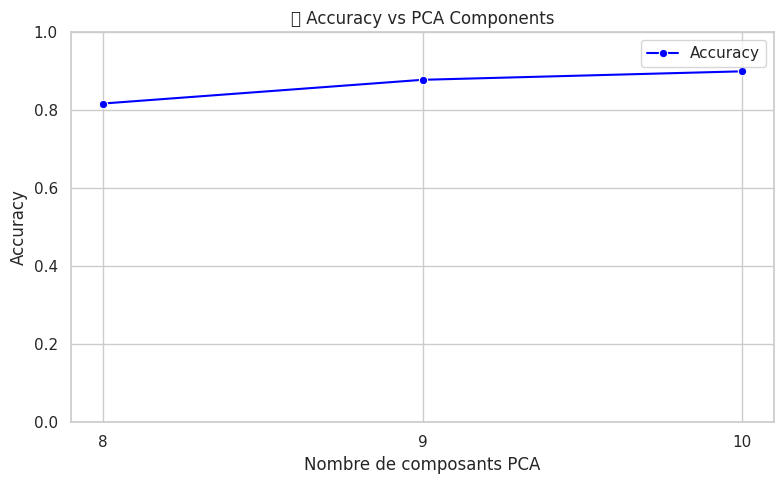

<ipython-input-9-4ed499315b45>:30: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


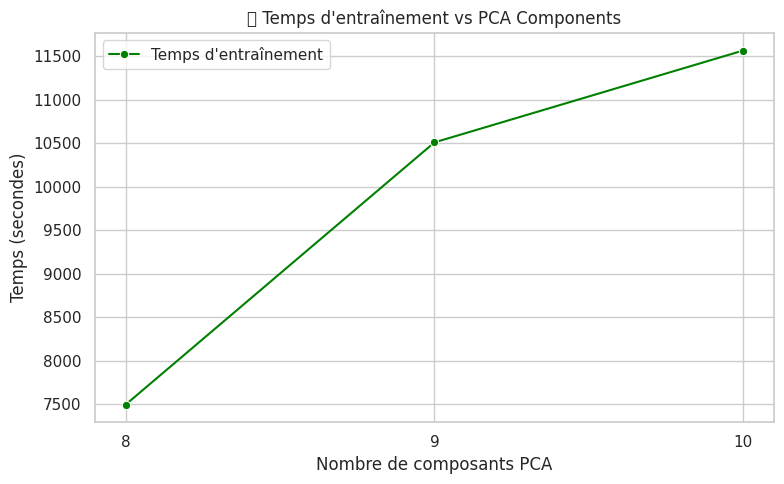

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les résultats
df_results = pd.read_csv("quantum_svm_results.csv")

# Style graphique
sns.set(style="whitegrid")

# ➤ Graphique 1 : Accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_results, x="PCA_components", y="Accuracy", marker='o', label="Accuracy", color="blue")
plt.title("📊 Accuracy vs PCA Components")
plt.xlabel("Nombre de composants PCA")
plt.ylabel("Accuracy")
plt.xticks(df_results["PCA_components"])
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Graphique 2 : Temps d'entraînement
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_results, x="PCA_components", y="Train_time", marker='o', label="Temps d'entraînement", color="green")
plt.title("⏱️ Temps d'entraînement vs PCA Components")
plt.xlabel("Nombre de composants PCA")
plt.ylabel("Temps (secondes)")
plt.xticks(df_results["PCA_components"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pennylane as qml
import numpy as np
import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Suppose que X_scaled et y sont déjà disponibles

# PCA = 8
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

num_qubits = X_train_resampled.shape[1]

device = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(device)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(num_qubits))
    qml.adjoint(qml.templates.IQPEmbedding)(weights, wires=range(num_qubits))
    return qml.probs(wires=range(num_qubits))

def qkernel(X1, X2):
    return np.array([[qnode(x1, x2)[0] for x2 in X2] for x1 in X1])

start_time = time.time()
qsvm = SVC(kernel=qkernel, C=1000, gamma='scale')
qsvm.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

preds = qsvm.predict(X_test)

# Calculer toutes les métriques
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average="weighted", zero_division=0)
recall = recall_score(y_test, preds, average="weighted", zero_division=0)
f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

# Stocker les résultats
results = [{
    "PCA_components": n_components,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1_Score": f1,
    "Train_time": end_time - start_time
}]

# Sauvegarder
df_result = pd.DataFrame(results)
df_result.to_csv("pca8_result_qsvm_iqp.csv", index=False)
print(f"PCA {n_components} -> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
files.download("pca8_result_qsvm_iqp.csv")

PCA 8 -> Accuracy: 0.8043, Precision: 0.8126, Recall: 0.8043, F1: 0.8056


NameError: name 'files' is not defined

In [ ]:
from google.colab import files
files.download("pca8_result_qsvm_iqp.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pennylane as qml
import numpy as np
import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from google.colab import files
# Suppose que X_scaled et y sont déjà disponibles

# PCA = 9
n_components = 9
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

num_qubits = X_train_resampled.shape[1]

device = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(device)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(num_qubits))
    qml.adjoint(qml.templates.IQPEmbedding)(weights, wires=range(num_qubits))
    return qml.probs(wires=range(num_qubits))

def qkernel(X1, X2):
    return np.array([[qnode(x1, x2)[0] for x2 in X2] for x1 in X1])

start_time = time.time()
qsvm = SVC(kernel=qkernel, C=1000, gamma='scale')
qsvm.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

preds = qsvm.predict(X_test)

# Calculer toutes les métriques
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average="weighted", zero_division=0)
recall = recall_score(y_test, preds, average="weighted", zero_division=0)
f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

# Stocker les résultats
results = [{
    "PCA_components": n_components,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1_Score": f1,
    "Train_time": end_time - start_time
}]

# Sauvegarder
df_result = pd.DataFrame(results)
df_result.to_csv("pca9_result_qsvm_iqp.csv", index=False)
print(f"PCA {n_components} -> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
files.download("pca9_result_qsvm_iqp.csv")

PCA 9 -> Accuracy: 0.8478, Precision: 0.8501, Recall: 0.8478, F1: 0.8468


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pennylane as qml
import numpy as np
import time
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from google.colab import files
# Suppose que X_scaled et y sont déjà disponibles

# PCA = 10
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

num_qubits = X_train_resampled.shape[1]

device = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(device)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(num_qubits))
    qml.adjoint(qml.templates.IQPEmbedding)(weights, wires=range(num_qubits))
    return qml.probs(wires=range(num_qubits))

def qkernel(X1, X2):
    return np.array([[qnode(x1, x2)[0] for x2 in X2] for x1 in X1])

start_time = time.time()
qsvm = SVC(kernel=qkernel, C=1000, gamma='scale')
qsvm.fit(X_train_resampled, y_train_resampled)
end_time = time.time()

preds = qsvm.predict(X_test)

# Calculer toutes les métriques
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average="weighted", zero_division=0)
recall = recall_score(y_test, preds, average="weighted", zero_division=0)
f1 = f1_score(y_test, preds, average="weighted", zero_division=0)

# Stocker les résultats
results = [{
    "PCA_components": n_components,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1_Score": f1,
    "Train_time": end_time - start_time
}]

# Sauvegarder
df_result = pd.DataFrame(results)
df_result.to_csv("pca10_result_qsvm_iqp.csv", index=False)
print(f"PCA {n_components} -> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
files.download("pca10_result_qsvm_iqp.csv")

In [ ]:
import pandas as pd
from google.colab import files

# Cette ligne ouvre une boîte de dialogue pour choisir le fichier sur ton PC
uploaded = files.upload()
df10 = pd.read_csv("pca10_result_qsvm_iqp.csv")
df10

Saving pca10_result_qsvm_iqp.csv to pca10_result_qsvm_iqp.csv


,PCA_components,Accuracy,Precision,Recall,F1_Score,Train_time
0,10,0.865626,0.870509,0.837113,0.846811,52792.712372


Saving pca8_result_qsvm_iqp.csv to pca8_result_qsvm_iqp.csv


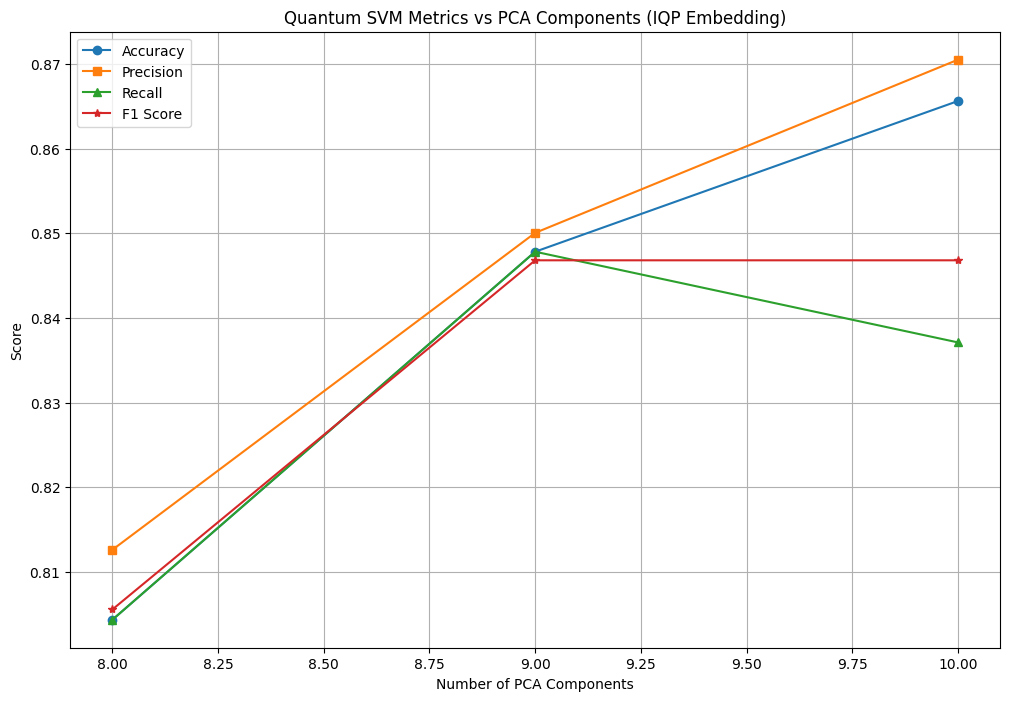

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Cette ligne ouvre une boîte de dialogue pour choisir le fichier sur ton PC
uploaded = files.upload()
# Charger tous les résultats
df8 = pd.read_csv("pca8_result_qsvm_iqp.csv")
df9 = pd.read_csv("pca9_result_qsvm_iqp.csv")
df10 = pd.read_csv("pca10_result_qsvm_iqp.csv")

# Regrouper
df_all = pd.concat([df8, df9, df10], ignore_index=True)

# Affichage graphique
plt.figure(figsize=(12,8))

# Accuracy
plt.plot(df_all["PCA_components"], df_all["Accuracy"], marker="o", label="Accuracy")
# Precision
plt.plot(df_all["PCA_components"], df_all["Precision"], marker="s", label="Precision")
# Recall
plt.plot(df_all["PCA_components"], df_all["Recall"], marker="^", label="Recall")
# F1 Score
plt.plot(df_all["PCA_components"], df_all["F1_Score"], marker="*", label="F1 Score")

plt.xlabel("Number of PCA Components")
plt.ylabel("Score")
plt.title("Quantum SVM Metrics vs PCA Components (IQP Embedding)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import pennylane as qml
from google.colab import files

# Pour enregistrer les résultats
results = []

# Liste des valeurs de PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running QkNN with PCA = {pca_n}")

    # Appliquer PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Appliquer SMOTE uniquement sur le training
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Déterminer le nombre de qubits = nombre de features
    num_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def fidelity_circuit(x1, x2):
        qml.templates.AngleEmbedding(x1, wires=range(num_qubits))
        qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    def quantum_fidelity(x1, x2):
        return fidelity_circuit(x1, x2)[0]

    def quantum_knn_predict(X_train, y_train, X_test, k=1):
        predictions = []
        for x_test in X_test:
            similarities = []
            for i, x_train in enumerate(X_train):
                sim = quantum_fidelity(x_test, x_train)
                similarities.append(sim)
            top_k_indices = np.argsort(similarities)[-k:]
            top_k_labels = [y_train[i] for i in top_k_indices]
            most_common = Counter(top_k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return predictions

    # Exécuter QkNN
    print(f"⏱️  Running prediction with QkNN (PCA={pca_n})...")
    y_pred_qknn = quantum_knn_predict(X_train_resampled, list(y_train_resampled), X_test)

    # Évaluer
    accuracy = accuracy_score(y_test, y_pred_qknn)
    precision = precision_score(y_test, y_pred_qknn, average='weighted')
    recall = recall_score(y_test, y_pred_qknn, average='weighted')
    f1 = f1_score(y_test, y_pred_qknn, average='weighted')

    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1
    })

# 📁 Enregistrer dans un fichier CSV
results_df = pd.DataFrame(results)
results_df.to_csv("results_qknn_pca.csv", index=False)

# 📥 Pour Google Colab : créer un lien de téléchargement
files.download("results_qknn_pca.csv")



🔧 Running QkNN with PCA = 8
⏱️  Running prediction with QkNN (PCA=8)...
✅ PCA = 8 → Accuracy: 0.7783, F1: 0.7859

🔧 Running QkNN with PCA = 9
⏱️  Running prediction with QkNN (PCA=9)...
✅ PCA = 9 → Accuracy: 0.8000, F1: 0.8065

🔧 Running QkNN with PCA = 10
⏱️  Running prediction with QkNN (PCA=10)...
✅ PCA = 10 → Accuracy: 0.8043, F1: 0.8088


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pandas as pd
# Cette ligne ouvre une boîte de dialogue pour choisir le fichier sur ton PC
uploaded = files.upload()
results_df = pd.read_csv("results_qknn_pca.csv")
results_df


Saving results_qknn_pca.csv to results_qknn_pca.csv


,PCA_components,Accuracy,Precision,Recall,F1_Score
0,8,0.778261,0.799448,0.778261,0.785939
1,9,0.800000,0.818851,0.800000,0.806536
2,10,0.804348,0.819940,0.804348,0.808767


<ipython-input-11-de62dae508a9>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


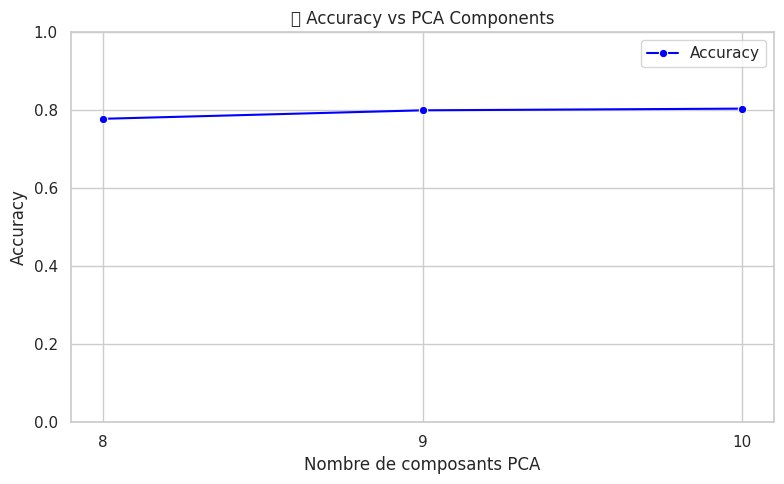

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les résultats
results_df = pd.read_csv("results_qknn_pca.csv")

# Style graphique
sns.set(style="whitegrid")

# ➤ Graphique 1 : Accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="PCA_components", y="Accuracy", marker='o', label="Accuracy", color="blue")
plt.title("📊 Accuracy vs PCA Components")
plt.xlabel("Nombre de composants PCA")
plt.ylabel("Accuracy")
plt.xticks(results_df["PCA_components"])
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import pennylane as qml
from google.colab import files

# Pour enregistrer les résultats
results = []

# Liste des valeurs de PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running QkNN with PCA = {pca_n}")

    # Appliquer PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Appliquer SMOTE uniquement sur le training
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Déterminer le nombre de qubits = nombre de features
    num_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def fidelity_circuit(x1, x2):
        qml.templates.AngleEmbedding(x1, wires=range(num_qubits))
        qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    def quantum_fidelity(x1, x2):
        return fidelity_circuit(x1, x2)[0]

    def quantum_knn_predict(X_train, y_train, X_test, k=1):
        predictions = []
        for x_test in X_test:
            similarities = []
            for i, x_train in enumerate(X_train):
                sim = quantum_fidelity(x_test, x_train)
                similarities.append(sim)
            top_k_indices = np.argsort(similarities)[-k:]
            top_k_labels = [y_train[i] for i in top_k_indices]
            most_common = Counter(top_k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return predictions

    # ⏱️ Mesurer le temps d'entraînement + prédiction
    start_time = time.time()

    print(f"⏱️  Running prediction with QkNN (PCA={pca_n})...")
    y_pred_qknn = quantum_knn_predict(X_train_resampled, list(y_train_resampled), X_test)

    end_time = time.time()
    elapsed_time = end_time - start_time  # Temps en secondes

    # Évaluer
    accuracy = accuracy_score(y_test, y_pred_qknn)
    precision = precision_score(y_test, y_pred_qknn, average='weighted')
    recall = recall_score(y_test, y_pred_qknn, average='weighted')
    f1 = f1_score(y_test, y_pred_qknn, average='weighted')

    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {elapsed_time:.2f} sec")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": elapsed_time
    })

# 📁 Enregistrer dans un fichier CSV
results_df = pd.DataFrame(results)
results_df.to_csv("results_qknn_angle.csv", index=False)

# 📥 Pour Google Colab : créer un lien de téléchargement




🔧 Running QkNN with PCA = 8
⏱️  Running prediction with QkNN (PCA=8)...
✅ PCA = 8 → Accuracy: 0.7783, F1: 0.7859, Time: 1263.34 sec

🔧 Running QkNN with PCA = 9
⏱️  Running prediction with QkNN (PCA=9)...
✅ PCA = 9 → Accuracy: 0.8000, F1: 0.8065, Time: 1426.87 sec

🔧 Running QkNN with PCA = 10
⏱️  Running prediction with QkNN (PCA=10)...
✅ PCA = 10 → Accuracy: 0.8043, F1: 0.8088, Time: 1581.44 sec


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pandas as pd
# Cette ligne ouvre une boîte de dialogue pour choisir le fichier sur ton PC
uploaded = files.upload()
results_df = pd.read_csv("results_qknn_angle.csv")
results_df

Saving results_qknn_angle.csv to results_qknn_angle (1).csv


,PCA_components,Accuracy,Precision,Recall,F1_Score,Training_Time_s
0,8,0.778261,0.799448,0.778261,0.785939,1263.342128
1,9,0.800000,0.818851,0.800000,0.806536,1426.872528
2,10,0.804348,0.819940,0.804348,0.808767,1581.441453


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import pennylane as qml
import time  # Import time for measuring duration
from google.colab import files

# Pour enregistrer les résultats
results = []

# Liste des valeurs de PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running QkNN with PCA = {pca_n}")

    # Appliquer PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Appliquer SMOTE uniquement sur le training
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Déterminer le nombre de qubits = nombre de features
    num_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def fidelity_circuit(x1, x2):
        # Utiliser IQP embedding au lieu de Angle Embedding
        qml.templates.IQPEmbedding(x1, wires=range(num_qubits))
        qml.adjoint(qml.templates.IQPEmbedding)(x2, wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))

    def quantum_fidelity(x1, x2):
        return fidelity_circuit(x1, x2)[0]

    def quantum_knn_predict(X_train, y_train, X_test, k=1):
        predictions = []
        for x_test in X_test:
            similarities = []
            for i, x_train in enumerate(X_train):
                sim = quantum_fidelity(x_test, x_train)
                similarities.append(sim)
            top_k_indices = np.argsort(similarities)[-k:]
            top_k_labels = [y_train[i] for i in top_k_indices]
            most_common = Counter(top_k_labels).most_common(1)[0][0]
            predictions.append(most_common)
        return predictions

    # Mesurer le temps d'exécution
    start_time = time.time()
    # Exécuter QkNN
    print(f"⏱️  Running prediction with QkNN (PCA={pca_n})...")
    y_pred_qknn = quantum_knn_predict(X_train_resampled, list(y_train_resampled), X_test)
    train_time = time.time() - start_time

    # Évaluer
    accuracy = accuracy_score(y_test, y_pred_qknn)
    precision = precision_score(y_test, y_pred_qknn, average='weighted')
    recall = recall_score(y_test, y_pred_qknn, average='weighted')
    f1 = f1_score(y_test, y_pred_qknn, average='weighted')

    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Train Time: {train_time:.2f} seconds")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Train_time": train_time  # Ajoutez le temps d'entraînement
    })

# 📁 Enregistrer dans un fichier CSV
results_df = pd.DataFrame(results)
results_df.to_csv("results_qknn_iqp.csv", index=False)

# 📥 Pour Google Colab : créer un lien de téléchargement
files.download("results_qknn_iqp.csv")


🔧 Running QkNN with PCA = 8
⏱️  Running prediction with QkNN (PCA=8)...
✅ PCA = 8 → Accuracy: 0.7609, F1: 0.7679, Train Time: 3944.12 seconds

🔧 Running QkNN with PCA = 9
⏱️  Running prediction with QkNN (PCA=9)...
✅ PCA = 9 → Accuracy: 0.7870, F1: 0.7922, Train Time: 5278.71 seconds

🔧 Running QkNN with PCA = 10
⏱️  Running prediction with QkNN (PCA=10)...
✅ PCA = 10 → Accuracy: 0.7957, F1: 0.7974, Train Time: 7346.88 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import pandas as pd
# Cette ligne ouvre une boîte de dialogue pour choisir le fichier sur ton PC
uploaded = files.upload()
results_df = pd.read_csv("results_qknn_iqp.csv")
results_df

Saving results_qknn_iqp.csv to results_qknn_iqp.csv


,PCA_components,Accuracy,Precision,Recall,F1_Score,Train_time
0,8,0.760870,0.780539,0.760870,0.767879,3944.124040
1,9,0.786957,0.801166,0.786957,0.792234,5278.709822
2,10,0.795652,0.809263,0.795652,0.797444,7346.880999


<ipython-input-8-5a0b2520faa6>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


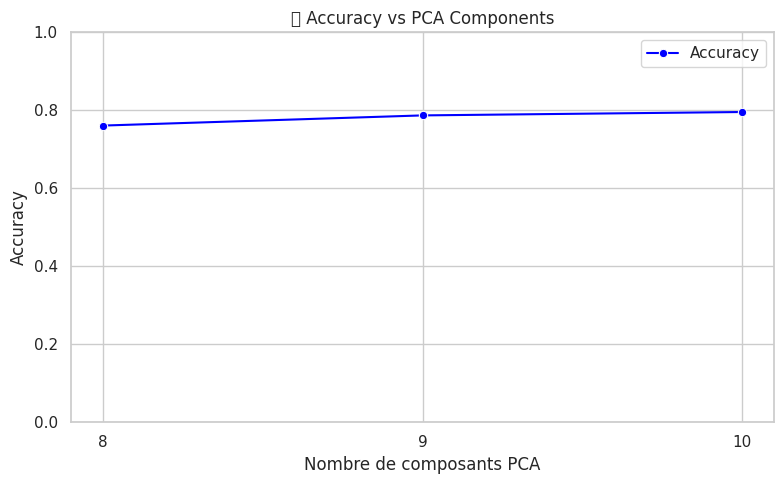

<ipython-input-8-5a0b2520faa6>:31: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


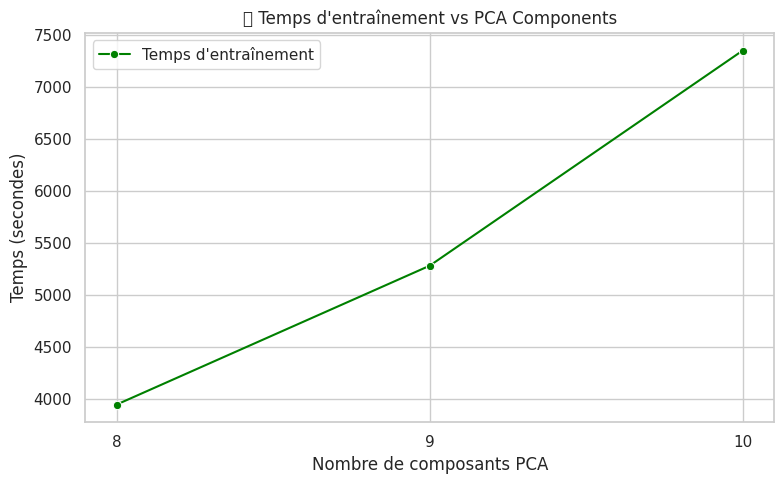

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les résultats
results_df = pd.read_csv("results_qknn_iqp.csv")

# Style graphique
sns.set(style="whitegrid")

# ➤ Graphique 1 : Accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="PCA_components", y="Accuracy", marker='o', label="Accuracy", color="blue")
plt.title("📊 Accuracy vs PCA Components")
plt.xlabel("Nombre de composants PCA")
plt.ylabel("Accuracy")
plt.xticks(results_df["PCA_components"])
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# ➤ Graphique 2 : Temps d'entraînement
plt.figure(figsize=(8, 5))
sns.lineplot(data=results_df, x="PCA_components", y="Train_time", marker='o', label="Temps d'entraînement", color="green")
plt.title("⏱️ Temps d'entraînement vs PCA Components")
plt.xlabel("Nombre de composants PCA")
plt.ylabel("Temps (secondes)")
plt.xticks(results_df["PCA_components"])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pennylane as qml
from pennylane.qnn import KerasLayer
from google.colab import files

# 💾 Stockage des résultats
results = []

# 🔁 Liste des composantes PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running Hybrid QNN with PCA = {pca_n}")
    start_time = time.time()  # ⏱️ Début

    # PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Quantum circuit
    n_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='tf')
    def quantum_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    weight_shapes = {"weights": (6, n_qubits, 3)}
    quantum_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

    # Encodage des labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)

    # Modèle hybride
    def hybrid_model(X_train, y_train, X_test, y_test):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(n_qubits, activation='relu'),
            quantum_layer,
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=20,
                  batch_size=32,
                  verbose=0)
        return model

    model = hybrid_model(X_train_resampled, y_train_encoded, X_test, y_test_encoded)

    # Prédiction
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test_encoded)

    # Scores
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    training_time = time.time() - start_time  # ⏱️ Fin
    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": training_time
    })

# 🧾 Enregistrement dans un fichier
results_df = pd.DataFrame(results)
results_df.to_csv("results_qnn_hybrid.csv", index=False)
files.download("results_qnn_hybrid.csv")



🔧 Running Hybrid QNN with PCA = 8


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 906ms/step
✅ PCA = 8 → Accuracy: 0.6565, F1: 0.6798, Time: 418.75s

🔧 Running Hybrid QNN with PCA = 9


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
✅ PCA = 9 → Accuracy: 0.7087, F1: 0.7173, Time: 815.48s

🔧 Running Hybrid QNN with PCA = 10


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
✅ PCA = 10 → Accuracy: 0.7609, F1: 0.7673, Time: 1668.50s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Charger les résultats depuis le fichier CSV
results_df = pd.read_csv("results_qnn_hybrid.csv")

# Afficher le DataFrame pour vérifier
results_df


,PCA_components,Accuracy,Precision,Recall,F1_Score,Training_Time_s
0,8,0.656522,0.792354,0.656522,0.679750,418.754230
1,9,0.708696,0.746583,0.708696,0.717274,815.475533
2,10,0.760870,0.804751,0.760870,0.767262,1668.497468


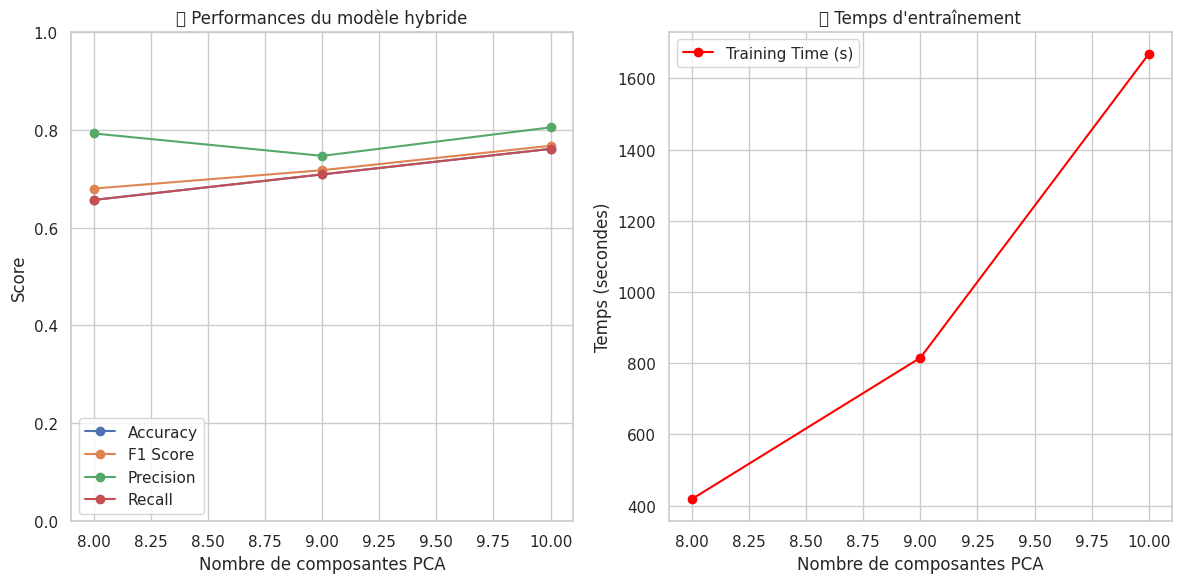

In [ ]:
import matplotlib.pyplot as plt

# 📊 Visualisation des scores
plt.figure(figsize=(12, 6))

# Sous-graphique 1 : Scores de performance
plt.subplot(1, 2, 1)
plt.plot(results_df["PCA_components"], results_df["Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["PCA_components"], results_df["F1_Score"], marker='o', label='F1 Score')
plt.plot(results_df["PCA_components"], results_df["Precision"], marker='o', label='Precision')
plt.plot(results_df["PCA_components"], results_df["Recall"], marker='o', label='Recall')
plt.title("📊 Performances du modèle hybride")
plt.xlabel("Nombre de composantes PCA")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Sous-graphique 2 : Temps d'entraînement
plt.subplot(1, 2, 2)
plt.plot(results_df["PCA_components"], results_df["Training_Time_s"], marker='o', color='red', label='Training Time (s)')
plt.title("⏱️ Temps d'entraînement")
plt.xlabel("Nombre de composantes PCA")
plt.ylabel("Temps (secondes)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pennylane as qml
from pennylane.qnn import KerasLayer
from google.colab import files

# 💾 Stockage des résultats
results = []

# 🔁 Liste des composantes PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running Hybrid QNN with PCA = {pca_n}")
    start_time = time.time()  # ⏱️ Début

    # PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Quantum circuit
    n_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='tf')
    def quantum_circuit(inputs, weights):
        qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]


    weight_shapes = {"weights": (6, n_qubits, 3)}
    quantum_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

    # Encodage des labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)

    # Modèle hybride
    def hybrid_model(X_train, y_train, X_test, y_test):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(n_qubits, activation='relu'),
            quantum_layer,
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=20,
                  batch_size=32,
                  verbose=0)
        return model

    model = hybrid_model(X_train_resampled, y_train_encoded, X_test, y_test_encoded)

    # Prédiction
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test_encoded)

    # Scores
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    training_time = time.time() - start_time  # ⏱️ Fin
    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": training_time
    })

# 🧾 Enregistrement dans un fichier
results_df = pd.DataFrame(results)
results_df.to_csv("results_qnn_hybrid_iqp.csv", index=False)
files.download("results_qnn_hybrid_iqp.csv")



🔧 Running Hybrid QNN with PCA = 8


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step
✅ PCA = 8 → Accuracy: 0.6217, F1: 0.6161, Time: 374.04s

🔧 Running Hybrid QNN with PCA = 9


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step
✅ PCA = 9 → Accuracy: 0.7217, F1: 0.7373, Time: 496.97s

🔧 Running Hybrid QNN with PCA = 10


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step
✅ PCA = 10 → Accuracy: 0.7043, F1: 0.7083, Time: 653.05s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Charger les résultats depuis le fichier CSV
results_df = pd.read_csv("results_qnn_hybrid_iqp.csv")

# Afficher le DataFrame pour vérifier
results_df


,PCA_components,Accuracy,Precision,Recall,F1_Score,Training_Time_s
0,8,0.621739,0.679685,0.621739,0.616070,374.036999
1,9,0.721739,0.784891,0.721739,0.737339,496.972342
2,10,0.704348,0.744231,0.704348,0.708263,653.053967


<ipython-input-25-d1cf86e951c7>:28: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-d1cf86e951c7>:28: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


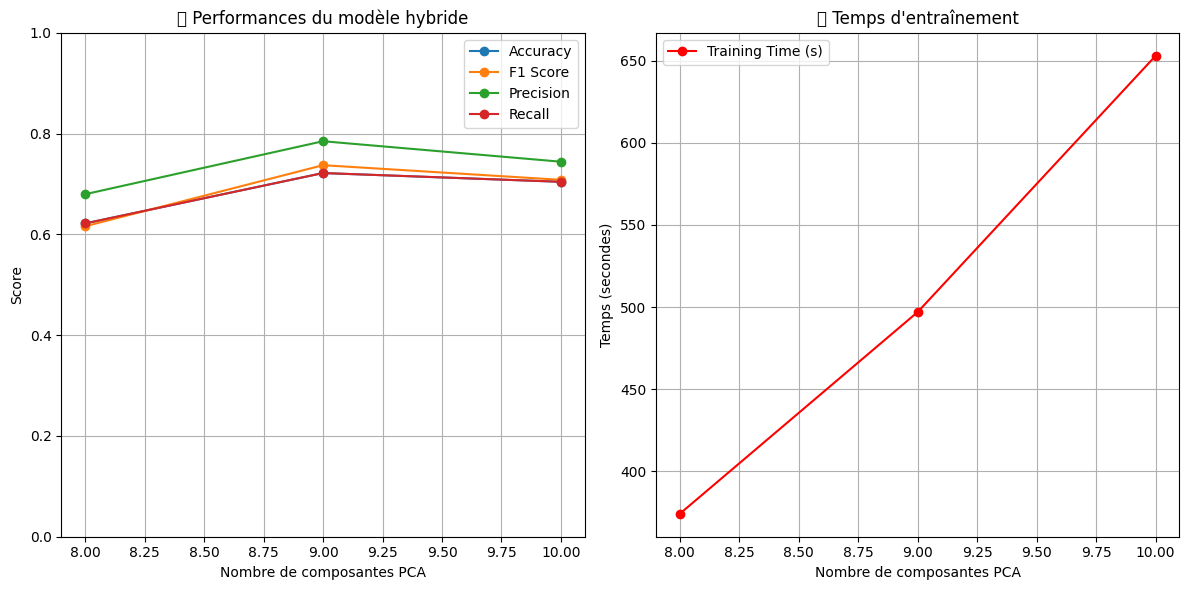

In [ ]:
import matplotlib.pyplot as plt

# 📊 Visualisation des scores
plt.figure(figsize=(12, 6))

# Sous-graphique 1 : Scores de performance
plt.subplot(1, 2, 1)
plt.plot(results_df["PCA_components"], results_df["Accuracy"], marker='o', label='Accuracy')
plt.plot(results_df["PCA_components"], results_df["F1_Score"], marker='o', label='F1 Score')
plt.plot(results_df["PCA_components"], results_df["Precision"], marker='o', label='Precision')
plt.plot(results_df["PCA_components"], results_df["Recall"], marker='o', label='Recall')
plt.title("📊 Performances du modèle hybride")
plt.xlabel("Nombre de composantes PCA")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Sous-graphique 2 : Temps d'entraînement
plt.subplot(1, 2, 2)
plt.plot(results_df["PCA_components"], results_df["Training_Time_s"], marker='o', color='red', label='Training Time (s)')
plt.title("⏱️ Temps d'entraînement")
plt.xlabel("Nombre de composantes PCA")
plt.ylabel("Temps (secondes)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pennylane as qml
from pennylane.qnn import KerasLayer
from google.colab import files

# 💾 Stockage des résultats
results = []

# 🔁 Liste des composantes PCA à tester
pca_components_list = [2, 3,4,5,6,7]

for pca_n in pca_components_list:
    print(f"\n🔧 Running Hybrid QNN with PCA = {pca_n}")
    start_time = time.time()  # ⏱️ Début

    # PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Quantum circuit
    n_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='tf')
    def quantum_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    weight_shapes = {"weights": (6, n_qubits, 3)}
    quantum_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

    # Encodage des labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)

    # Modèle hybride
    def hybrid_model(X_train, y_train, X_test, y_test):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(n_qubits, activation='relu'),
            quantum_layer,
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=20,
                  batch_size=32,
                  verbose=0)
        return model

    model = hybrid_model(X_train_resampled, y_train_encoded, X_test, y_test_encoded)

    # Prédiction
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test_encoded)

    # Scores
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    training_time = time.time() - start_time  # ⏱️ Fin
    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": training_time
    })

# 🧾 Enregistrement dans un fichier
results_df = pd.DataFrame(results)
results_df.to_csv("results_qnn_hybrid_pc2345.csv", index=False)
files.download("results_qnn_hybrid_pc2345.csv")



🔧 Running Hybrid QNN with PCA = 2


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step
✅ PCA = 2 → Accuracy: 0.5043, F1: 0.4833, Time: 30.64s

🔧 Running Hybrid QNN with PCA = 3


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 323ms/step
✅ PCA = 3 → Accuracy: 0.4870, F1: 0.4961, Time: 54.72s

🔧 Running Hybrid QNN with PCA = 4


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step
✅ PCA = 4 → Accuracy: 0.6000, F1: 0.5900, Time: 49.60s

🔧 Running Hybrid QNN with PCA = 5


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 703ms/step
✅ PCA = 5 → Accuracy: 0.6913, F1: 0.7079, Time: 68.34s

🔧 Running Hybrid QNN with PCA = 6


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step
✅ PCA = 6 → Accuracy: 0.7348, F1: 0.7494, Time: 105.03s

🔧 Running Hybrid QNN with PCA = 7


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 861ms/step
✅ PCA = 7 → Accuracy: 0.7000, F1: 0.7094, Time: 136.54s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Charger les résultats depuis le fichier CSV
results_df = pd.read_csv("results_qnn_hybrid_pc2345.csv")

# Afficher le DataFrame pour vérifier
results_df

,PCA_components,Accuracy,Precision,Recall,F1_Score,Training_Time_s
0,2,0.504348,0.519773,0.504348,0.483290,30.639904
1,3,0.486957,0.550697,0.486957,0.496140,54.715302
2,4,0.600000,0.636357,0.600000,0.590014,49.602124
3,5,0.691304,0.754135,0.691304,0.707903,68.336620
4,6,0.734783,0.795498,0.734783,0.749392,105.032078
5,7,0.700000,0.773440,0.700000,0.709424,136.543670


Saving quantum_svm_results.csv to quantum_svm_results (2).csv


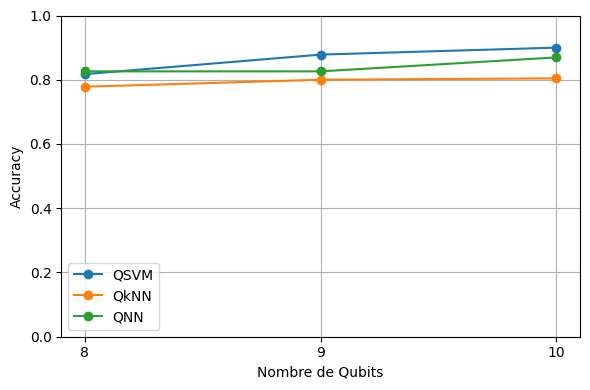

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

# Uploader les trois fichiers nécessaires
uploaded = files.upload()

# Charger les fichiers CSV
df_qsvm = pd.read_csv("quantum_svm_results.csv")

df_qknn = pd.read_csv("results_qknn_angle.csv")

df_qnn  = pd.read_csv("results_qnn_hybrid_epoch100.csv")

# Fusionner les données sur PCA_components
comparison_df = pd.DataFrame({
    'PCA_components': df_qsvm['PCA_components'],
    'QSVM': df_qsvm['Accuracy'],
    'QkNN': df_qknn['Accuracy'],
    'QNN': df_qnn['Accuracy']
})

# Tracer le graphique
plt.figure(figsize=(6, 4))
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM'], marker='o', label='QSVM')
plt.plot(comparison_df['PCA_components'], comparison_df['QkNN'], marker='o', label='QkNN')
plt.plot(comparison_df['PCA_components'], comparison_df['QNN'],  marker='o', label='QNN')

plt.xlabel('Nombre de Qubits')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Saving quantum_svm_results.csv to quantum_svm_results (1).csv


Saving results_qknn_angle.csv to results_qknn_angle.csv


Saving results_qnn_hybrid_epoch100.csv to results_qnn_hybrid_epoch100 (3).csv


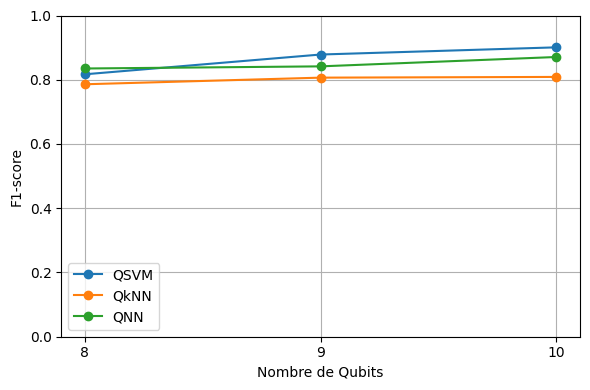

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from google.colab import files

# Uploader les trois fichiers nécessaires
uploaded = files.upload()
df_qsvm = pd.read_csv("quantum_svm_results.csv")
uploaded = files.upload()
df_qknn = pd.read_csv("results_qknn_angle.csv")
uploaded = files.upload()
df_qnn = pd.read_csv("results_qnn_hybrid_epoch100.csv")

# Extraire F1-score du rapport de classification de QSVM
f1_scores_qsvm = []
for report in df_qsvm['Classification_Report']:
    parsed = ast.literal_eval(report)  # Convertir string en dict
    f1 = parsed['weighted avg']['f1-score']
    f1_scores_qsvm.append(f1)

# Créer DataFrame comparatif
comparison_df = pd.DataFrame({
    'PCA_components': df_qsvm['PCA_components'],
    'QSVM': f1_scores_qsvm,
    'QkNN': df_qknn['F1_Score'],
    'QNN': df_qnn['F1_Score']
})

# Tracer le graphique
plt.figure(figsize=(6, 4))
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM'], marker='o', label='QSVM')
plt.plot(comparison_df['PCA_components'], comparison_df['QkNN'], marker='o', label='QkNN')
plt.plot(comparison_df['PCA_components'], comparison_df['QNN'],  marker='o', label='QNN')

plt.xlabel('Nombre de Qubits')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Saving pca8_result_qsvm_iqp.csv to pca8_result_qsvm_iqp (1).csv


Saving pca9_result_qsvm_iqp.csv to pca9_result_qsvm_iqp.csv


Saving pca10_result_qsvm_iqp.csv to pca10_result_qsvm_iqp.csv


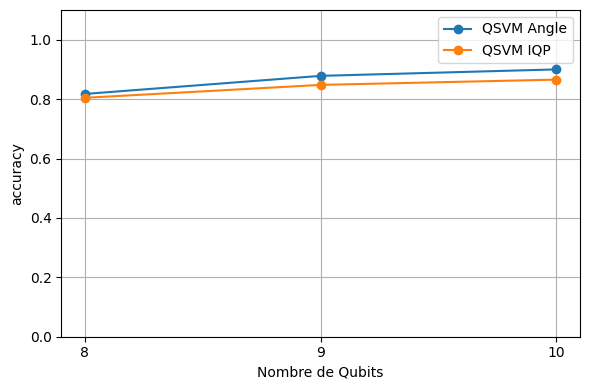

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
# 📤 Uploader les fichiers QSVM IQP (répète cette cellule 1 seule fois)
uploaded = files.upload()
# 📚 Charger et concaténer les 3 fichiers
df_iqp_8 = pd.read_csv("pca8_result_qsvm_iqp.csv")
uploaded = files.upload()
df_iqp_9 = pd.read_csv("pca9_result_qsvm_iqp.csv")
uploaded = files.upload()
df_iqp_10 = pd.read_csv("pca10_result_qsvm_iqp.csv")



# Concaténer
df_qsvm_iqp = pd.concat([df_iqp_8, df_iqp_9, df_iqp_10], ignore_index=True)

df_qsvm_angle = pd.read_csv("quantum_svm_results.csv")  # adapte le nom si nécessaire
comparison_df = pd.DataFrame({
    'PCA_components': df_qsvm_angle['PCA_components'],
    'QSVM_Angle': df_qsvm_angle['Accuracy'],  # ou 'Accuracy'
    'QSVM_IQP': df_qsvm_iqp['Accuracy']
})


plt.figure(figsize=(6, 4))
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM_Angle'], marker='o', label='QSVM Angle')
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM_IQP'], marker='o', label='QSVM IQP')


plt.xlabel('Nombre de Qubits')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


Saving results_qknn_angle.csv to results_qknn_angle (1).csv


Saving results_qknn_iqp.csv to results_qknn_iqp.csv


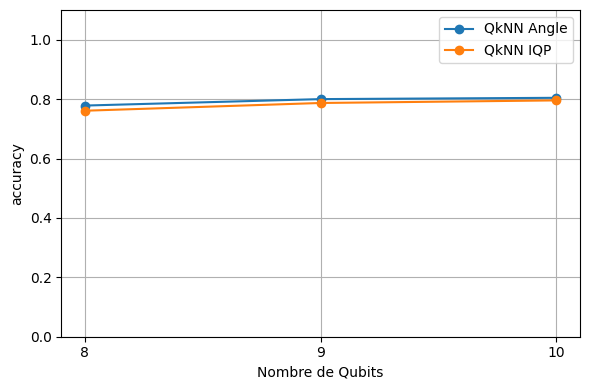

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
uploaded = files.upload()  # Upload 'qknn_angle.csv' et 'qknn_iqp.csv'
df_qknn_angle = pd.read_csv("results_qknn_angle.csv")
uploaded = files.upload()
df_qknn_iqp = pd.read_csv("results_qknn_iqp.csv")
comparison_qknn = pd.DataFrame({
    'PCA_components': df_qknn_angle['PCA_components'],
    'QkNN_Angle': df_qknn_angle['Accuracy'],
    'QkNN_IQP': df_qknn_iqp['Accuracy']
})


plt.figure(figsize=(6, 4))
plt.plot(comparison_qknn['PCA_components'], comparison_qknn['QkNN_Angle'], marker='o', label='QkNN Angle')
plt.plot(comparison_qknn['PCA_components'], comparison_qknn['QkNN_IQP'], marker='o', label='QkNN IQP')


plt.xlabel('Nombre de Qubits')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


Saving results_qnn_hybrid_epoch100.csv to results_qnn_hybrid_epoch100 (2).csv


Saving results_qnn_hybrid_iqp_epoch100.csv to results_qnn_hybrid_iqp_epoch100 (1).csv


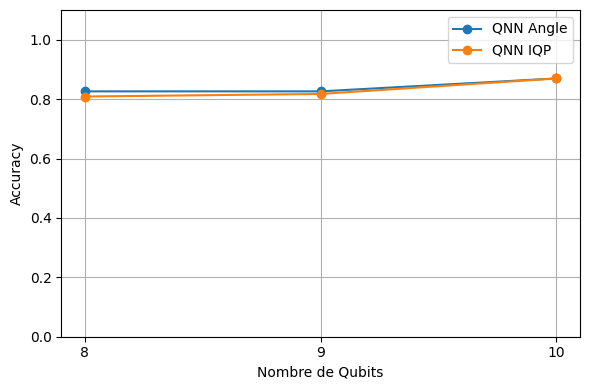

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
uploaded = files.upload()
df_qnn_angle = pd.read_csv("results_qnn_hybrid_epoch100.csv")
uploaded = files.upload()
df_qnn_iqp   = pd.read_csv("results_qnn_hybrid_iqp_epoch100.csv")
comparison_qnn = pd.DataFrame({
    'PCA_components': df_qnn_angle['PCA_components'],
    'QNN_Angle': df_qnn_angle['Accuracy'],
    'QNN_IQP': df_qnn_iqp['Accuracy']
})


plt.figure(figsize=(6, 4))
plt.plot(comparison_qnn['PCA_components'], comparison_qnn['QNN_Angle'], marker='o', label='QNN Angle')
plt.plot(comparison_qnn['PCA_components'], comparison_qnn['QNN_IQP'], marker='o', label='QNN IQP')


plt.xlabel('Nombre de Qubits')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


Saving quantum_svm_results.csv to quantum_svm_results (20).csv


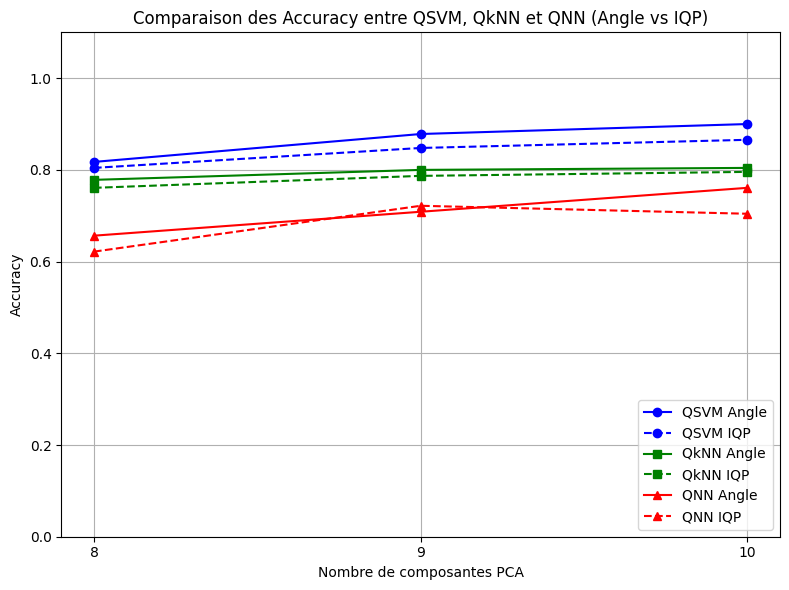

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 📤 Uploader tous les fichiers nécessaires
from google.colab import files
uploaded = files.upload()

# 📚 Charger les fichiers QSVM
df_qsvm_angle = pd.read_csv("quantum_svm_results.csv")
df_qsvm_iqp_8 = pd.read_csv("pca8_result_qsvm_iqp.csv")
df_qsvm_iqp_9 = pd.read_csv("pca9_result_qsvm_iqp.csv")
df_qsvm_iqp_10 = pd.read_csv("pca10_result_qsvm_iqp.csv")
df_qsvm_iqp = pd.concat([df_qsvm_iqp_8, df_qsvm_iqp_9, df_qsvm_iqp_10], ignore_index=True)

# 📚 Charger les fichiers QkNN
df_qknn_angle = pd.read_csv("results_qknn_angle.csv")
df_qknn_iqp = pd.read_csv("results_qknn_iqp.csv")

# 📚 Charger les fichiers QNN
df_qnn_angle = pd.read_csv("results_qnn_hybrid.csv")
df_qnn_iqp = pd.read_csv("results_qnn_hybrid_iqp.csv")

# 📊 Création d'un DataFrame de comparaison
comparison_df = pd.DataFrame({
    'PCA_components': df_qsvm_angle['PCA_components'],

    'QSVM_Angle': df_qsvm_angle['Accuracy'],
    'QSVM_IQP': df_qsvm_iqp['Accuracy'],

    'QkNN_Angle': df_qknn_angle['Accuracy'],
    'QkNN_IQP': df_qknn_iqp['Accuracy'],

    'QNN_Angle': df_qnn_angle['Accuracy'],
    'QNN_IQP': df_qnn_iqp['Accuracy']
})

# 🎨 **Tracer le graphique combiné**
plt.figure(figsize=(8, 6))

# QSVM
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM_Angle'], marker='o', linestyle='-', label='QSVM Angle', color='blue')
plt.plot(comparison_df['PCA_components'], comparison_df['QSVM_IQP'], marker='o', linestyle='--', label='QSVM IQP', color='blue')

# QkNN
plt.plot(comparison_df['PCA_components'], comparison_df['QkNN_Angle'], marker='s', linestyle='-', label='QkNN Angle', color='green')
plt.plot(comparison_df['PCA_components'], comparison_df['QkNN_IQP'], marker='s', linestyle='--', label='QkNN IQP', color='green')

# QNN
plt.plot(comparison_df['PCA_components'], comparison_df['QNN_Angle'], marker='^', linestyle='-', label='QNN Angle', color='red')
plt.plot(comparison_df['PCA_components'], comparison_df['QNN_IQP'], marker='^', linestyle='--', label='QNN IQP', color='red')

# **Personnalisation**
plt.xlabel('Nombre de composantes PCA')
plt.ylabel('Accuracy')
plt.title('Comparaison des Accuracy entre QSVM, QkNN et QNN (Angle vs IQP)')
plt.legend(loc='lower right')
plt.grid(True)
plt.xticks([8, 9, 10])
plt.ylim(0, 1.1)
plt.tight_layout()

# **Afficher le graphique**
plt.show()


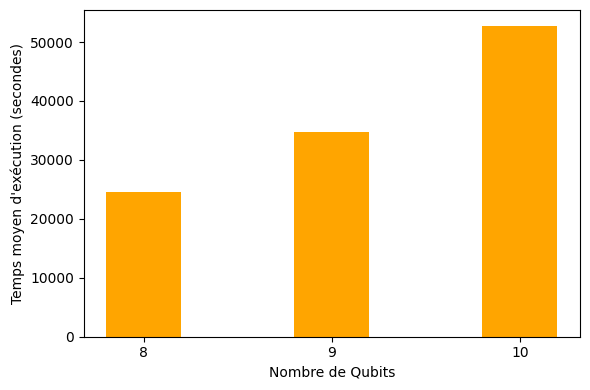

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# 📚 Charger les fichiers QSVM IQP
df_qsvm_iqp_8 = pd.read_csv("pca8_result_qsvm_iqp.csv")
df_qsvm_iqp_9 = pd.read_csv("pca9_result_qsvm_iqp.csv")
df_qsvm_iqp_10 = pd.read_csv("pca10_result_qsvm_iqp.csv")

# 📊 Préparer les données pour le graphique
times = [
    df_qsvm_iqp_8["Train_time"].mean(),
    df_qsvm_iqp_9["Train_time"].mean(),
    df_qsvm_iqp_10["Train_time"].mean()
]

pca_components = [8, 9, 10]
indices = range(len(pca_components))  # Pour contrôler l'espacement

# 🎨 Tracer le diagramme en barres
plt.figure(figsize=(6, 4))
plt.bar(indices, times, color='orange', width=0.4)

plt.xlabel("Nombre de Qubits")
plt.ylabel("Temps moyen d'exécution (secondes)")
plt.xticks(indices, pca_components)
plt.tight_layout()
plt.show()


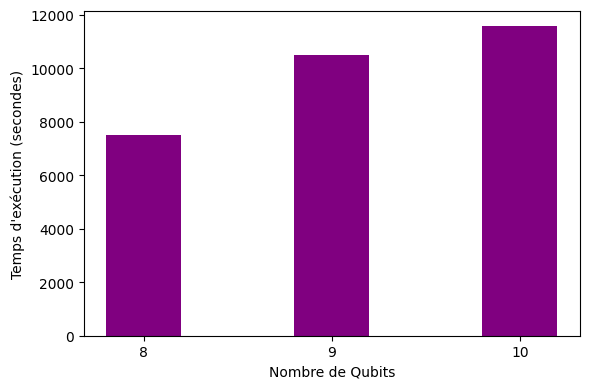

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files


# 📚 Charger le fichier QSVM Angle
df_qsvm_angle = pd.read_csv("quantum_svm_results.csv")

# ✅ Extraire les temps d'entraînement et les composants PCA
times = df_qsvm_angle["Train_time"].tolist()
pca_components = df_qsvm_angle["PCA_components"].tolist()

# Convertir en indices rapprochés pour réduire l'espacement
indices = range(len(pca_components))  # [0, 1, 2]

# 🎨 Tracer le diagramme en barres
plt.figure(figsize=(6, 4))
plt.bar(indices, times, color='purple', width=0.4)
plt.xlabel("Nombre de Qubits")
plt.ylabel("Temps d'exécution (secondes)")


# Ajouter les vraies valeurs de PCA sur l'axe X
plt.xticks(indices, pca_components)
plt.tight_layout()
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pennylane as qml
from pennylane.qnn import KerasLayer
from google.colab import files

# 💾 Stockage des résultats
results = []

# 🔁 Liste des composantes PCA à tester
pca_components_list = [8,9,10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running Hybrid QNN with PCA = {pca_n}")
    start_time = time.time()  # ⏱️ Début

    # PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Quantum circuit
    n_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='tf')
    def quantum_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

    weight_shapes = {"weights": (6, n_qubits, 3)}
    quantum_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

    # Encodage des labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)

    # Modèle hybride
    def hybrid_model(X_train, y_train, X_test, y_test):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(n_qubits, activation='relu'),
            quantum_layer,
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=100,
                  batch_size=32,
                  verbose=0)
        return model

    model = hybrid_model(X_train_resampled, y_train_encoded, X_test, y_test_encoded)

    # Prédiction
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test_encoded)

    # Scores
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    training_time = time.time() - start_time  # ⏱️ Fin
    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": training_time
    })

results_df = pd.DataFrame(results)
results_df.to_csv("results_qnn_hybrid_epoch100.csv", index=False)
files.download("results_qnn_hybrid_epoch100.csv")


🔧 Running Hybrid QNN with PCA = 8


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
✅ PCA = 8 → Accuracy: 0.8261, F1: 0.8350, Time: 2021.19s

🔧 Running Hybrid QNN with PCA = 9


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
✅ PCA = 9 → Accuracy: 0.8261, F1: 0.8417, Time: 3845.72s

🔧 Running Hybrid QNN with PCA = 10


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
✅ PCA = 10 → Accuracy: 0.8696, F1: 0.8708, Time: 8048.96s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pennylane as qml
from pennylane.qnn import KerasLayer
from google.colab import files

# 💾 Stockage des résultats
results = []

# 🔁 Liste des composantes PCA à tester
pca_components_list = [8, 9, 10]

for pca_n in pca_components_list:
    print(f"\n🔧 Running Hybrid QNN with PCA = {pca_n}")
    start_time = time.time()  # ⏱️ Début

    # PCA
    pca = PCA(n_components=pca_n)
    X_pca = pca.fit_transform(X_scaled)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Quantum circuit
    n_qubits = X_train_resampled.shape[1]
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface='tf')
    def quantum_circuit(inputs, weights):
        qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]


    weight_shapes = {"weights": (6, n_qubits, 3)}
    quantum_layer = KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)

    # Encodage des labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_resampled)
    y_test_encoded = label_encoder.transform(y_test)

    # Modèle hybride
    def hybrid_model(X_train, y_train, X_test, y_test):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(n_qubits, activation='relu'),
            quantum_layer,
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  epochs=100,
                  batch_size=32,
                  verbose=0)
        return model

    model = hybrid_model(X_train_resampled, y_train_encoded, X_test, y_test_encoded)

    # Prédiction
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_test_encoded)

    # Scores
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

    training_time = time.time() - start_time  # ⏱️ Fin
    print(f"✅ PCA = {pca_n} → Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.2f}s")

    results.append({
        "PCA_components": pca_n,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "Training_Time_s": training_time
    })

# 🧾 Enregistrement dans un fichier
results_df = pd.DataFrame(results)
results_df.to_csv("results_qnn_hybrid_iqp_epoch100.csv", index=False)
files.download("results_qnn_hybrid_iqp_epoch100.csv")
results_df



🔧 Running Hybrid QNN with PCA = 8


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
✅ PCA = 8 → Accuracy: 0.8087, F1: 0.8178, Time: 2098.18s

🔧 Running Hybrid QNN with PCA = 9


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
✅ PCA = 9 → Accuracy: 0.8174, F1: 0.8314, Time: 4500.52s

🔧 Running Hybrid QNN with PCA = 10


/usr/local/lib/python3.11/dist-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
✅ PCA = 10 → Accuracy: 0.8696, F1: 0.8689, Time: 13435.77s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,PCA_components,Accuracy,Precision,Recall,F1_Score,Training_Time_s
0,8,0.808696,0.839426,0.808696,0.817800,2098.176028
1,9,0.817391,0.861971,0.817391,0.831390,4500.518782
2,10,0.869565,0.875908,0.869565,0.868874,13435.770555
